In [ ]:
# Install required packages
!pip install torch torchvision numpy opencv-python matplotlib
!pip install kagglehub

In [ ]:
import kagglehub
import os
import shutil
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Download latest version (optional; use if not already added in Kaggle)
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")
print("Path to dataset files (raw download):", path)

# Set data_dir to the correct subdirectory based on the provided structure
data_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version"
print("Adjusted data directory:", data_dir)

# Verify structure
print("Dataset structure:")
!ls -R {data_dir}

Path to dataset files (raw download): /kaggle/input/the-wildfire-dataset
Adjusted data directory: /kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version
Dataset structure:
/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version:
test  train  val

/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test:
fire  nofire

/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/fire:
19196558588_267f24b847_o.jpg  50323624771_c50229c6f9_o.jpg
20960888741_8c4be2c1df_o.jpg  50331586642_e1f77b7c27_o.jpg
26131736898_9e6a8cd68f_o.jpg  50380652301_a49c4c245b_o.jpg
26549039025_b4cce14ec7_o.jpg  50380846762_05de20fe60_o.jpg
27002088114_aa5cc7f353_o.jpg  50380847162_24a484981b_o.jpg
27335331950_39b376eddd_o.jpg  50408559278_10f041ed61_o.jpg
27389369514_cd30397ac2_o.jpg  50517815722_17ae2240d2_o.jpg
27951228213_2dd961ac1f_o.jpg  50517815882_2959039cc0_o.jpg
27968020506_5f1a59f2a5_o.jpg  50575966873_8cef16dcc6_o.jpg
28020330864_d7a2429a7e_o.jpg  5062

In [ ]:
# The dataset is already organized with test, train, and val splits
# No reorganization needed as the dataset is pre-split into train, val, and test with fire and nofire
# This cell is a placeholder to verify the structure
print("Dataset structure confirmed at:", data_dir)
!ls -R {data_dir}

Dataset structure confirmed at: /kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version
/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version:
test  train  val

/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test:
fire  nofire

/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/fire:
19196558588_267f24b847_o.jpg  50323624771_c50229c6f9_o.jpg
20960888741_8c4be2c1df_o.jpg  50331586642_e1f77b7c27_o.jpg
26131736898_9e6a8cd68f_o.jpg  50380652301_a49c4c245b_o.jpg
26549039025_b4cce14ec7_o.jpg  50380846762_05de20fe60_o.jpg
27002088114_aa5cc7f353_o.jpg  50380847162_24a484981b_o.jpg
27335331950_39b376eddd_o.jpg  50408559278_10f041ed61_o.jpg
27389369514_cd30397ac2_o.jpg  50517815722_17ae2240d2_o.jpg
27951228213_2dd961ac1f_o.jpg  50517815882_2959039cc0_o.jpg
27968020506_5f1a59f2a5_o.jpg  50575966873_8cef16dcc6_o.jpg
28020330864_d7a2429a7e_o.jpg  50622019883_c988dcf6ba_o.jpg
28347651877_ce21ed134e_o.png  50622843556_679c9aec75_o.jpg
2

In [ ]:
# Define transforms for Inception V3 (input size: 299x299)
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val", "test"]
}

# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ["train", "val", "test"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes  # ['fire', 'nofire']
print("Class names:", class_names)
print("Dataset sizes:", dataset_sizes)

Class names: ['fire', 'nofire']
Dataset sizes: {'train': 1887, 'val': 402, 'test': 410}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pre-trained Inception V3
model = models.inception_v3(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: fire, nofire

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("Inception V3 model prepared for training!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda:0
Inception V3 model prepared for training!


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    if phase == "train":
                        outputs = model(inputs)
                        if isinstance(outputs, tuple):
                            outputs = outputs[0]
                        loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f"Best validation Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=5)

# Save the trained model
torch.save(model.state_dict(), "/content/inceptionv3_wildfire.pth")
print("Model saved to /content/inceptionv3_wildfire.pth")

Epoch 1/5
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train Loss: 0.3718 Acc: 0.8288
val Loss: 0.4639 Acc: 0.8383

Epoch 2/5
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train Loss: 0.2113 Acc: 0.9210
val Loss: 0.3389 Acc: 0.8731

Epoch 3/5
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train Loss: 0.1758 Acc: 0.9327
val Loss: 0.5608 Acc: 0.8682

Epoch 4/5
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train Loss: 0.1403 Acc: 0.9534
val Loss: 0.3119 Acc: 0.8856

Epoch 5/5
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train Loss: 0.1310 Acc: 0.9491
val Loss: 0.2503 Acc: 0.9104

Best validation Acc: 0.9104
Model saved to /content/inceptionv3_wildfire.pth


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    return accuracy, precision, recall, f1

# Evaluate
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, dataloaders["test"])
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy: 0.9122
Test Precision: 0.9536
Test Recall: 0.9004
Test F1 Score: 0.9262


Processing image: /content/abc337.jpg


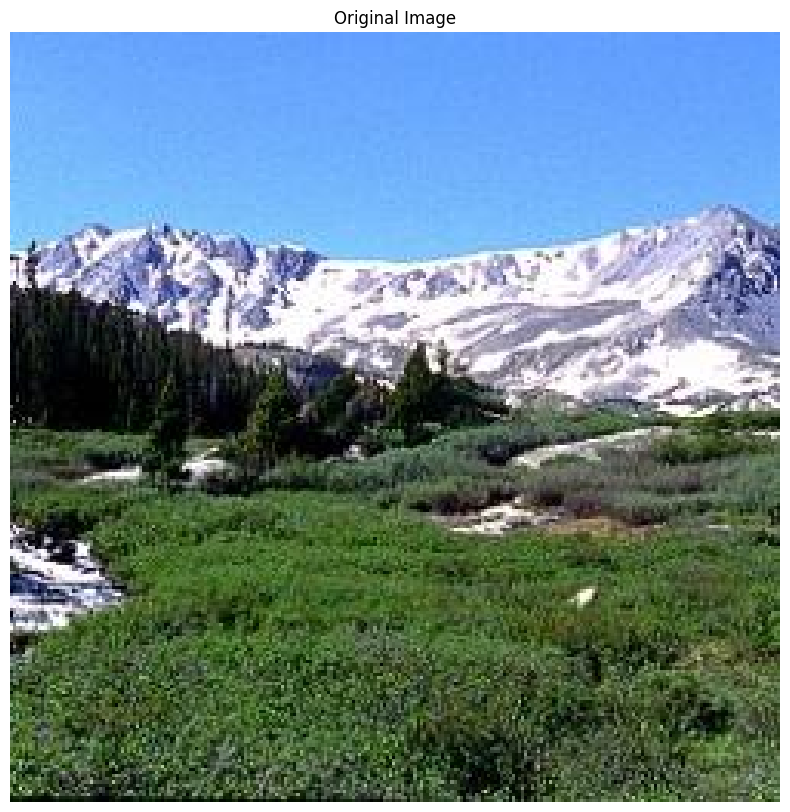

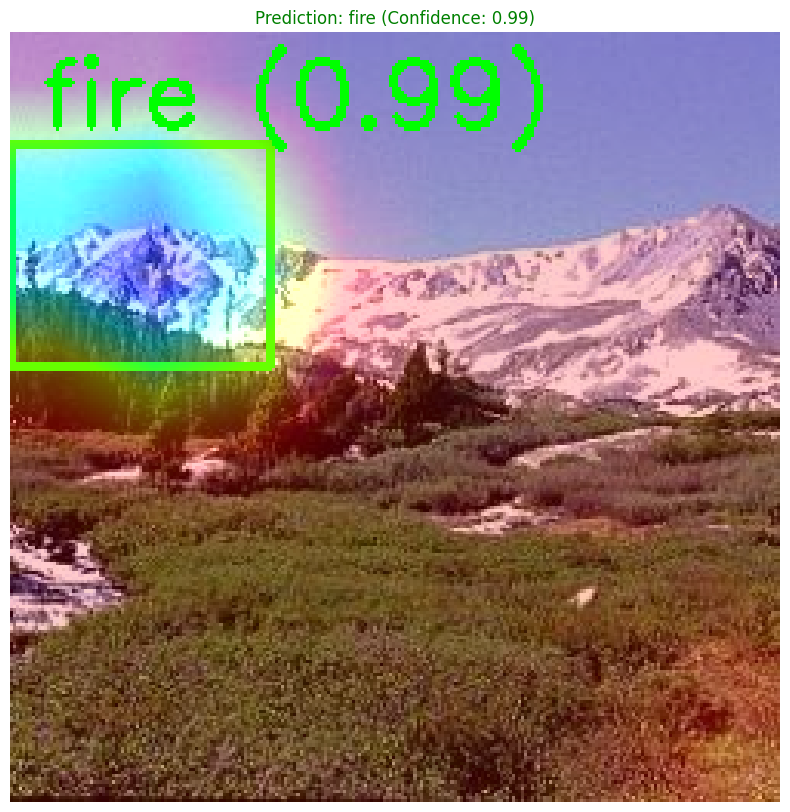

Prediction: fire
Confidence: 0.99
Output saved to /content/output/abc337_classified.png


In [ ]:
from google.colab import files

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, class_idx=None):
        input_image.requires_grad_()
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        gradients = self.gradients
        activations = self.activations
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)
        heatmap = torch.mean(activations * pooled_gradients, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.cpu().detach().numpy(), class_idx

# Specify the image path (example from test set)
img_path = os.path.join(data_dir, "/content/abc337.jpg")

# Verify image exists
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found at {img_path}. Available files: {os.listdir(os.path.join(data_dir, 'test/nofire'))}")
print("Processing image:", img_path)

# Load image in original format
image = Image.open(img_path)
original_mode = image.mode  # e.g., 'L', 'RGB', 'RGBA'
image_np = np.array(image)  # Keep original format

# Display original image
plt.figure(figsize=(10, 10))
plt.imshow(image_np, cmap='gray' if original_mode == 'L' else None)
plt.axis("off")
plt.title("Original Image")
plt.show()

# Convert to RGB for model inference
image_rgb = image.convert("RGB")
image_tensor = data_transforms["test"](image_rgb).unsqueeze(0).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    confidence = torch.softmax(outputs, dim=1)[0][pred].item()
    predicted_class = class_names[pred.item()]

# Initialize output image in original format
output_image = image_np.copy()

# Apply Grad-CAM if fire is detected
if predicted_class == "fire":
    # Use the last convolutional layer
    target_layer = model.Mixed_7c
    grad_cam = GradCAM(model, target_layer)
    heatmap, _ = grad_cam.generate(image_tensor)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Convert heatmap to original image mode
    if original_mode == 'L':
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2GRAY)
    elif original_mode == 'RGBA':
        heatmap = cv2.cvtColor(cv2.cvtColor(heatmap, cv2.COLOR_GRAY2RGB), cv2.COLOR_RGB2RGBA)
    else:
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Threshold heatmap for bounding boxes
    if original_mode == 'L':
        _, thresh = cv2.threshold(heatmap, 150, 255, cv2.THRESH_BINARY)
    else:
        _, thresh = cv2.threshold(heatmap[:, :, 2], 150, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    for contour in contours:
        if cv2.contourArea(contour) > 100:
            x, y, w, h = cv2.boundingRect(contour)
            color = 255 if original_mode == 'L' else (0, 255, 0)
            if original_mode == 'RGBA':
                color = (0, 255, 0, 255)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)

    # Overlay heatmap if not grayscale
    if original_mode != 'L':
        output_image = cv2.addWeighted(output_image, 0.8, heatmap, 0.4, 0)

# Add prediction text
color = 255 if original_mode == 'L' else (0, 255, 0) if predicted_class == "fire" else (0, 0, 255)
if original_mode == 'RGBA':
    color = (0, 255, 0, 255) if predicted_class == "fire" else (0, 0, 255, 255)
cv2.putText(output_image, f"{predicted_class} ({confidence:.2f})", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

# Display processed image
plt.figure(figsize=(10, 10))
plt.imshow(output_image, cmap='gray' if original_mode == 'L' else None)
plt.axis("off")
plt.title(f"Prediction: {predicted_class} (Confidence: {confidence:.2f})",
          color="green" if predicted_class == "fire" else "red")
plt.show()

# Print result
print(f"Prediction: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# Save output image in original format
output_dir = "/content/output"
os.makedirs(output_dir, exist_ok=True)
base_name = os.path.splitext(os.path.basename(img_path))[0]
output_path = os.path.join(output_dir, f"{base_name}_classified.png")
output_image_pil = Image.fromarray(output_image, mode=original_mode)
output_image_pil.save(output_path, format="PNG")
print(f"Output saved to {output_path}")

# Optional: Download output
# files.download(output_path)